# Convolutional Neural Networks

__Prerequisites__

- [Neural Networks](https://github.com/AI-Core/Neural-Networks/blob/master/Neural%20Networks.ipynb)

The fully connected neural network we looked at in the previous lesson takes in a vector as input thus a flattened image could be passed in as input and used for classification problems successfully. But this is not the best way to do it. When trying to interpret an image, the spatial relations between the different pixels is crucial to our understanding. When we flatten the image, we lose this information.

Convolutional neural networks solve this very problem. Rather than performing a matrix multiplication, a convolution operation is performed which can take in a 2d input and give a 2d output hence keep the information about the spatial relations of the pixels. This greatly increases their performance on image and video processing tasks.

In the convolution proccess, you have a filter which you start on the top left side of the image and slide across the whole image, taking a dot product between the values of the filter and pixel values of the image. Bear in mind that colour images have three colour channels so your filter may be 3d so you take the dot product across a 3d volume. Each dot product corresponds to a single activation value in a 2d matrix of neurons which corresponds to a single layer in the output.

![image](images/CNN_RGB.JPG)

The animation below shows how a 1x3x3 filter is applied to a 1x5x5 image. Notice how the output has high  values when the filter is passed over locations where there is an X shape in the input image. This is because the values of the filter are such that it is performing pattern matching for the X shape.

![image](images/convolution_animation.gif)

Convolution operations have 3 parameters, the kernel size, which is the width and height of our filter, the stride, which is the number of pixels we translate our kernel by to compute the next feature, and the padding which is how many layers of 0 padding we add to the input image. We som

![image](images/CNN_diagram.JPG)

Each computed feature is a linear function of the pixels in a local region as opposed to fully connected nets where each computed feature is a linear function of all the pixels in the image.

We have some prior understanding of how image data should be processed. We apply the same set of weights at different locations all over the image because we know that features are repeated at different locations throughout the image. This makes the learned features translation invariant.


![image](images/CNN_FNN_comparison.JPG)


For a long time, operations like this were used in computer vision to find different patterns in images with the engineers having to manually tune the values of the filters to perform the required function. The only difference now is that we apply an activation such as Relu or Sigmoid at each layer and after setting up the structure of the network, we initialize the filter values randomly before using gradient descent to automatically tune the values of the filters. We can also apply max pooling operations to subsample the output at each layer therefore reducing the number of parameters that need to be learned for the succeeding convolution operation.


Just like before, each layer in the whole network learns higher level abstract features from the inputs.

In [1]:
import torch
from torchvision import datasets, transforms

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=transforms.ToTensor(),          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=transforms.ToTensor(),
                           train=False,
                          )

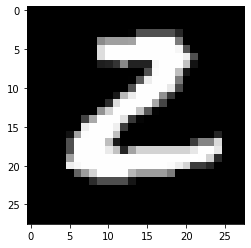

In [2]:
import matplotlib.pyplot as plt
import numpy as np
x = train_data[np.random.randint(0, 300)][0]    # get a random example
#print(x)
plt.imshow(x[0].numpy(),cmap='gray')
plt.show()

In [3]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

In [4]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

In [5]:
import torch.nn.functional as F
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
            # conv2d(in_channels, out_channels, kernel_size)
            # in_channels is the number of layers which it takes in (i.e.num color channels in 1st layer)
            # out_channels is the number of different filters that we use
            # kernel_size is the depthxwidthxheight of the kernel#
            # stride is how many pixels we shift the kernel by each time
        self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
            torch.nn.ReLU()
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(32*20*20, 10) # put your convolutional architecture here using torch.nn.Sequential 
        )
    def forward(self, x):
        x = self.conv_layers(x)# pass through conv layers
        x = x.view(x.shape[0], -1)# flatten output ready for fully connected layer
        x = self.fc_layers(x)# pass through fully connected layer
        x = F.softmax(x, dim=1)# softmax activation function on outputs
        return x

In [6]:
use_cuda = torch.cuda.is_available() #checks if gpu is available
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
learning_rate = 0.0005 # set learning rate
epochs = 5 # set number of epochs

cnn = ConvNet() #.to(device)#instantiate model
criterion = torch.nn.CrossEntropyLoss() #use cross entropy loss function
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
def train(model, epochs, verbose=True, tag='Loss/Train'):
    for epoch in range(epochs):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            # pass x through your model to get a prediction
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the cost
            if verbose: print('Epoch:', epoch, '\tBatch:', idx, '\tLoss:', loss.item())
            
            optimiser.zero_grad()                  # reset the gradients attribute of all of the model's params to zero
            loss.backward()                        # backward pass to compute and store all of the model's param's gradients
            optimiser.step()                       # update the model's parameters
            
            writer.add_scalar(tag, loss, epoch*len(train_loader) + idx)    # write loss to a graph
    print('Training Complete. Final loss =',loss.item())

In [9]:
from time import time
start = time()
train(cnn, epochs)
print('time taken:', time() - start)

Epoch: 0 	Batch: 0 	Loss: 2.3023204803466797
Epoch: 0 	Batch: 1 	Loss: 2.293855905532837
Epoch: 0 	Batch: 2 	Loss: 2.282557725906372
Epoch: 0 	Batch: 3 	Loss: 2.276531219482422
Epoch: 0 	Batch: 4 	Loss: 2.241830587387085
Epoch: 0 	Batch: 5 	Loss: 2.240964889526367
Epoch: 0 	Batch: 6 	Loss: 2.2257602214813232
Epoch: 0 	Batch: 7 	Loss: 2.1886038780212402
Epoch: 0 	Batch: 8 	Loss: 2.128694772720337
Epoch: 0 	Batch: 9 	Loss: 2.064389228820801
Epoch: 0 	Batch: 10 	Loss: 2.0461690425872803
Epoch: 0 	Batch: 11 	Loss: 1.9763458967208862
Epoch: 0 	Batch: 12 	Loss: 1.9658535718917847
Epoch: 0 	Batch: 13 	Loss: 1.9424477815628052
Epoch: 0 	Batch: 14 	Loss: 1.8840078115463257
Epoch: 0 	Batch: 15 	Loss: 1.8187620639801025
Epoch: 0 	Batch: 16 	Loss: 1.8242665529251099
Epoch: 0 	Batch: 17 	Loss: 1.8340113162994385
Epoch: 0 	Batch: 18 	Loss: 1.8173857927322388
Epoch: 0 	Batch: 19 	Loss: 1.7756268978118896
Epoch: 0 	Batch: 20 	Loss: 1.7275328636169434
Epoch: 0 	Batch: 21 	Loss: 1.7566258907318115
Epoch

Epoch: 0 	Batch: 181 	Loss: 1.7140676975250244
Epoch: 0 	Batch: 182 	Loss: 1.6012084484100342
Epoch: 0 	Batch: 183 	Loss: 1.5957220792770386
Epoch: 0 	Batch: 184 	Loss: 1.641563892364502
Epoch: 0 	Batch: 185 	Loss: 1.6133790016174316
Epoch: 0 	Batch: 186 	Loss: 1.67202627658844
Epoch: 0 	Batch: 187 	Loss: 1.636212706565857
Epoch: 0 	Batch: 188 	Loss: 1.641787052154541
Epoch: 0 	Batch: 189 	Loss: 1.6366937160491943
Epoch: 0 	Batch: 190 	Loss: 1.5995666980743408
Epoch: 0 	Batch: 191 	Loss: 1.581382155418396
Epoch: 0 	Batch: 192 	Loss: 1.5706340074539185
Epoch: 0 	Batch: 193 	Loss: 1.5853650569915771
Epoch: 0 	Batch: 194 	Loss: 1.608154296875
Epoch: 0 	Batch: 195 	Loss: 1.561804175376892
Epoch: 0 	Batch: 196 	Loss: 1.6292182207107544
Epoch: 0 	Batch: 197 	Loss: 1.6246535778045654
Epoch: 0 	Batch: 198 	Loss: 1.6374037265777588
Epoch: 0 	Batch: 199 	Loss: 1.6585594415664673
Epoch: 0 	Batch: 200 	Loss: 1.641361951828003
Epoch: 0 	Batch: 201 	Loss: 1.5883266925811768
Epoch: 0 	Batch: 202 	Los

Epoch: 0 	Batch: 361 	Loss: 1.603010892868042
Epoch: 0 	Batch: 362 	Loss: 1.5764633417129517
Epoch: 0 	Batch: 363 	Loss: 1.5998725891113281
Epoch: 0 	Batch: 364 	Loss: 1.581624150276184
Epoch: 0 	Batch: 365 	Loss: 1.5623894929885864
Epoch: 0 	Batch: 366 	Loss: 1.590279221534729
Epoch: 0 	Batch: 367 	Loss: 1.593650460243225
Epoch: 0 	Batch: 368 	Loss: 1.6028517484664917
Epoch: 0 	Batch: 369 	Loss: 1.6095980405807495
Epoch: 0 	Batch: 370 	Loss: 1.67770516872406
Epoch: 0 	Batch: 371 	Loss: 1.6095725297927856
Epoch: 0 	Batch: 372 	Loss: 1.5738474130630493
Epoch: 0 	Batch: 373 	Loss: 1.5672917366027832
Epoch: 0 	Batch: 374 	Loss: 1.5832558870315552
Epoch: 0 	Batch: 375 	Loss: 1.5995733737945557
Epoch: 0 	Batch: 376 	Loss: 1.626615285873413
Epoch: 0 	Batch: 377 	Loss: 1.6384879350662231
Epoch: 0 	Batch: 378 	Loss: 1.5839964151382446
Epoch: 0 	Batch: 379 	Loss: 1.5846731662750244
Epoch: 0 	Batch: 380 	Loss: 1.5853960514068604
Epoch: 0 	Batch: 381 	Loss: 1.5844664573669434
Epoch: 0 	Batch: 382

Epoch: 1 	Batch: 149 	Loss: 1.5043617486953735
Epoch: 1 	Batch: 150 	Loss: 1.4904876947402954
Epoch: 1 	Batch: 151 	Loss: 1.487488865852356
Epoch: 1 	Batch: 152 	Loss: 1.5405703783035278
Epoch: 1 	Batch: 153 	Loss: 1.5266612768173218
Epoch: 1 	Batch: 154 	Loss: 1.520258903503418
Epoch: 1 	Batch: 155 	Loss: 1.494449257850647
Epoch: 1 	Batch: 156 	Loss: 1.5155320167541504
Epoch: 1 	Batch: 157 	Loss: 1.5089572668075562
Epoch: 1 	Batch: 158 	Loss: 1.4992049932479858
Epoch: 1 	Batch: 159 	Loss: 1.4887661933898926
Epoch: 1 	Batch: 160 	Loss: 1.5205374956130981
Epoch: 1 	Batch: 161 	Loss: 1.5023967027664185
Epoch: 1 	Batch: 162 	Loss: 1.5009278059005737
Epoch: 1 	Batch: 163 	Loss: 1.4985874891281128
Epoch: 1 	Batch: 164 	Loss: 1.5083484649658203
Epoch: 1 	Batch: 165 	Loss: 1.5030169486999512
Epoch: 1 	Batch: 166 	Loss: 1.535423994064331
Epoch: 1 	Batch: 167 	Loss: 1.5256454944610596
Epoch: 1 	Batch: 168 	Loss: 1.515026330947876
Epoch: 1 	Batch: 169 	Loss: 1.508163332939148
Epoch: 1 	Batch: 17

Epoch: 1 	Batch: 327 	Loss: 1.4880386590957642
Epoch: 1 	Batch: 328 	Loss: 1.5132272243499756
Epoch: 1 	Batch: 329 	Loss: 1.470795750617981
Epoch: 1 	Batch: 330 	Loss: 1.5130550861358643
Epoch: 1 	Batch: 331 	Loss: 1.4897894859313965
Epoch: 1 	Batch: 332 	Loss: 1.4806727170944214
Epoch: 1 	Batch: 333 	Loss: 1.4911589622497559
Epoch: 1 	Batch: 334 	Loss: 1.4865132570266724
Epoch: 1 	Batch: 335 	Loss: 1.4993791580200195
Epoch: 1 	Batch: 336 	Loss: 1.5105358362197876
Epoch: 1 	Batch: 337 	Loss: 1.488644003868103
Epoch: 1 	Batch: 338 	Loss: 1.4917911291122437
Epoch: 1 	Batch: 339 	Loss: 1.5028972625732422
Epoch: 1 	Batch: 340 	Loss: 1.4773188829421997
Epoch: 1 	Batch: 341 	Loss: 1.4949651956558228
Epoch: 1 	Batch: 342 	Loss: 1.4689890146255493
Epoch: 1 	Batch: 343 	Loss: 1.5077959299087524
Epoch: 1 	Batch: 344 	Loss: 1.4961084127426147
Epoch: 1 	Batch: 345 	Loss: 1.4909074306488037
Epoch: 1 	Batch: 346 	Loss: 1.4815117120742798
Epoch: 1 	Batch: 347 	Loss: 1.4926986694335938
Epoch: 1 	Batch

Epoch: 2 	Batch: 114 	Loss: 1.4940974712371826
Epoch: 2 	Batch: 115 	Loss: 1.4876835346221924
Epoch: 2 	Batch: 116 	Loss: 1.4726943969726562
Epoch: 2 	Batch: 117 	Loss: 1.4894124269485474
Epoch: 2 	Batch: 118 	Loss: 1.4640047550201416
Epoch: 2 	Batch: 119 	Loss: 1.4944877624511719
Epoch: 2 	Batch: 120 	Loss: 1.4910838603973389
Epoch: 2 	Batch: 121 	Loss: 1.4855592250823975
Epoch: 2 	Batch: 122 	Loss: 1.5055603981018066
Epoch: 2 	Batch: 123 	Loss: 1.490584373474121
Epoch: 2 	Batch: 124 	Loss: 1.4693844318389893
Epoch: 2 	Batch: 125 	Loss: 1.4758678674697876
Epoch: 2 	Batch: 126 	Loss: 1.498379111289978
Epoch: 2 	Batch: 127 	Loss: 1.4939887523651123
Epoch: 2 	Batch: 128 	Loss: 1.4842689037322998
Epoch: 2 	Batch: 129 	Loss: 1.5112112760543823
Epoch: 2 	Batch: 130 	Loss: 1.4805067777633667
Epoch: 2 	Batch: 131 	Loss: 1.500488042831421
Epoch: 2 	Batch: 132 	Loss: 1.4874656200408936
Epoch: 2 	Batch: 133 	Loss: 1.4723318815231323
Epoch: 2 	Batch: 134 	Loss: 1.489522099494934
Epoch: 2 	Batch: 

Epoch: 2 	Batch: 290 	Loss: 1.4624625444412231
Epoch: 2 	Batch: 291 	Loss: 1.4779925346374512
Epoch: 2 	Batch: 292 	Loss: 1.482820987701416
Epoch: 2 	Batch: 293 	Loss: 1.472356915473938
Epoch: 2 	Batch: 294 	Loss: 1.4877655506134033
Epoch: 2 	Batch: 295 	Loss: 1.486107349395752
Epoch: 2 	Batch: 296 	Loss: 1.503881812095642
Epoch: 2 	Batch: 297 	Loss: 1.4763755798339844
Epoch: 2 	Batch: 298 	Loss: 1.4889986515045166
Epoch: 2 	Batch: 299 	Loss: 1.4991083145141602
Epoch: 2 	Batch: 300 	Loss: 1.4760527610778809
Epoch: 2 	Batch: 301 	Loss: 1.4883044958114624
Epoch: 2 	Batch: 302 	Loss: 1.5019409656524658
Epoch: 2 	Batch: 303 	Loss: 1.4779942035675049
Epoch: 2 	Batch: 304 	Loss: 1.4907809495925903
Epoch: 2 	Batch: 305 	Loss: 1.4792728424072266
Epoch: 2 	Batch: 306 	Loss: 1.4803035259246826
Epoch: 2 	Batch: 307 	Loss: 1.4847394227981567
Epoch: 2 	Batch: 308 	Loss: 1.4768165349960327
Epoch: 2 	Batch: 309 	Loss: 1.4837076663970947
Epoch: 2 	Batch: 310 	Loss: 1.4884113073349
Epoch: 2 	Batch: 311

Epoch: 3 	Batch: 77 	Loss: 1.4835822582244873
Epoch: 3 	Batch: 78 	Loss: 1.4731813669204712
Epoch: 3 	Batch: 79 	Loss: 1.4840123653411865
Epoch: 3 	Batch: 80 	Loss: 1.4635374546051025
Epoch: 3 	Batch: 81 	Loss: 1.4623444080352783
Epoch: 3 	Batch: 82 	Loss: 1.4794994592666626
Epoch: 3 	Batch: 83 	Loss: 1.4758365154266357
Epoch: 3 	Batch: 84 	Loss: 1.4746313095092773
Epoch: 3 	Batch: 85 	Loss: 1.5048127174377441
Epoch: 3 	Batch: 86 	Loss: 1.4616318941116333
Epoch: 3 	Batch: 87 	Loss: 1.4735254049301147
Epoch: 3 	Batch: 88 	Loss: 1.4836244583129883
Epoch: 3 	Batch: 89 	Loss: 1.4811146259307861
Epoch: 3 	Batch: 90 	Loss: 1.474069595336914
Epoch: 3 	Batch: 91 	Loss: 1.4773695468902588
Epoch: 3 	Batch: 92 	Loss: 1.4948575496673584
Epoch: 3 	Batch: 93 	Loss: 1.4655685424804688
Epoch: 3 	Batch: 94 	Loss: 1.4792098999023438
Epoch: 3 	Batch: 95 	Loss: 1.4921727180480957
Epoch: 3 	Batch: 96 	Loss: 1.4701615571975708
Epoch: 3 	Batch: 97 	Loss: 1.4666805267333984
Epoch: 3 	Batch: 98 	Loss: 1.461414

Epoch: 3 	Batch: 253 	Loss: 1.478721261024475
Epoch: 3 	Batch: 254 	Loss: 1.4856499433517456
Epoch: 3 	Batch: 255 	Loss: 1.4713112115859985
Epoch: 3 	Batch: 256 	Loss: 1.4962962865829468
Epoch: 3 	Batch: 257 	Loss: 1.4779576063156128
Epoch: 3 	Batch: 258 	Loss: 1.4856760501861572
Epoch: 3 	Batch: 259 	Loss: 1.4953951835632324
Epoch: 3 	Batch: 260 	Loss: 1.475582480430603
Epoch: 3 	Batch: 261 	Loss: 1.4907587766647339
Epoch: 3 	Batch: 262 	Loss: 1.4891170263290405
Epoch: 3 	Batch: 263 	Loss: 1.4913411140441895
Epoch: 3 	Batch: 264 	Loss: 1.4708808660507202
Epoch: 3 	Batch: 265 	Loss: 1.4984009265899658
Epoch: 3 	Batch: 266 	Loss: 1.4764704704284668
Epoch: 3 	Batch: 267 	Loss: 1.4807562828063965
Epoch: 3 	Batch: 268 	Loss: 1.475467562675476
Epoch: 3 	Batch: 269 	Loss: 1.4837231636047363
Epoch: 3 	Batch: 270 	Loss: 1.4657264947891235
Epoch: 3 	Batch: 271 	Loss: 1.4939727783203125
Epoch: 3 	Batch: 272 	Loss: 1.480033040046692
Epoch: 3 	Batch: 273 	Loss: 1.4893916845321655
Epoch: 3 	Batch: 

Epoch: 4 	Batch: 42 	Loss: 1.4673470258712769
Epoch: 4 	Batch: 43 	Loss: 1.479129433631897
Epoch: 4 	Batch: 44 	Loss: 1.4943292140960693
Epoch: 4 	Batch: 45 	Loss: 1.4635579586029053
Epoch: 4 	Batch: 46 	Loss: 1.4753371477127075
Epoch: 4 	Batch: 47 	Loss: 1.4926426410675049
Epoch: 4 	Batch: 48 	Loss: 1.466221570968628
Epoch: 4 	Batch: 49 	Loss: 1.4692574739456177
Epoch: 4 	Batch: 50 	Loss: 1.4747871160507202
Epoch: 4 	Batch: 51 	Loss: 1.4929887056350708
Epoch: 4 	Batch: 52 	Loss: 1.4636467695236206
Epoch: 4 	Batch: 53 	Loss: 1.4782041311264038
Epoch: 4 	Batch: 54 	Loss: 1.4857820272445679
Epoch: 4 	Batch: 55 	Loss: 1.4740041494369507
Epoch: 4 	Batch: 56 	Loss: 1.483005404472351
Epoch: 4 	Batch: 57 	Loss: 1.4828077554702759
Epoch: 4 	Batch: 58 	Loss: 1.4735666513442993
Epoch: 4 	Batch: 59 	Loss: 1.4854178428649902
Epoch: 4 	Batch: 60 	Loss: 1.4942947626113892
Epoch: 4 	Batch: 61 	Loss: 1.4848582744598389
Epoch: 4 	Batch: 62 	Loss: 1.488938570022583
Epoch: 4 	Batch: 63 	Loss: 1.465068578

Epoch: 4 	Batch: 219 	Loss: 1.4795089960098267
Epoch: 4 	Batch: 220 	Loss: 1.488156795501709
Epoch: 4 	Batch: 221 	Loss: 1.4839582443237305
Epoch: 4 	Batch: 222 	Loss: 1.479638934135437
Epoch: 4 	Batch: 223 	Loss: 1.477520227432251
Epoch: 4 	Batch: 224 	Loss: 1.4686086177825928
Epoch: 4 	Batch: 225 	Loss: 1.5001215934753418
Epoch: 4 	Batch: 226 	Loss: 1.4940319061279297
Epoch: 4 	Batch: 227 	Loss: 1.48404860496521
Epoch: 4 	Batch: 228 	Loss: 1.4743232727050781
Epoch: 4 	Batch: 229 	Loss: 1.4619231224060059
Epoch: 4 	Batch: 230 	Loss: 1.499787449836731
Epoch: 4 	Batch: 231 	Loss: 1.4770660400390625
Epoch: 4 	Batch: 232 	Loss: 1.4942458868026733
Epoch: 4 	Batch: 233 	Loss: 1.5083916187286377
Epoch: 4 	Batch: 234 	Loss: 1.4682570695877075
Epoch: 4 	Batch: 235 	Loss: 1.483481526374817
Epoch: 4 	Batch: 236 	Loss: 1.4724639654159546
Epoch: 4 	Batch: 237 	Loss: 1.475326657295227
Epoch: 4 	Batch: 238 	Loss: 1.4854639768600464
Epoch: 4 	Batch: 239 	Loss: 1.4829813241958618
Epoch: 4 	Batch: 240 

In [ ]:
import numpy as np
            
def calc_accuracy(model, dataloader):
    num_correct = 0
    num_examples = len(dataloader.dataset)                       # test DATA not test LOADER
    for inputs, labels in dataloader:                  # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
    percent_correct = num_correct / num_examples * 100
    return percent_correct

In [ ]:
print('Train Accuracy:', calc_accuracy(cnn, train_loader))
print('Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('Test Accuracy:', calc_accuracy(cnn, test_loader))

## Empirical Benchmarking of Fully Connected vs Convolutional Architecture on MNIST

Lets empirically test the translation invariance of the two architectures. 

The training set now has a center crop transformation which crops the central pixels of the image to a given size. However, the test set has a random crop transformation which crops a random region of the image to a given size.

So we are training the neural networks with a centrally cropped image but testing it on cropped images with translations applied.

The network that has more translation invariant features should performs better on this test set.

In [ ]:
import torch
from torchvision import datasets, transforms

crop_size = 22

traintransforms = []
traintransforms.append(transforms.CenterCrop(crop_size))
traintransforms.append(transforms.ToTensor())
traintransforms = transforms.Compose(traintransforms)

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=traintransforms,          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

testtransforms = []
testtransforms.append(transforms.RandomCrop(crop_size))
testtransforms.append(transforms.ToTensor())
testtransforms = transforms.Compose(testtransforms)

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=testtransforms,
                           train=False,
                          )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# PRINT THEIR LENGTHS AND VISUALISE AN EXAMPLE
x = train_data[np.random.randint(0, len(train_data))][0]    # get a random training example
print('Train Example')
plt.imshow(x[0].numpy())
plt.show()
x = test_data[np.random.randint(0, len(test_data))][0]    # get a random test example
print('Test Example')
plt.imshow(x[0].numpy())
plt.show()

In [ ]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

In [ ]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

We define the architectures of our fully connected and convolutional networks as well as a function which returns the number of parameters in each model. Since the number of parameters in a model is a rough measure of its capacity, the networks should have an approximately equal number of parameters to make it a fair comparison.

In [ ]:
import torch.nn.functional as F 

class FullyConnectedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(crop_size*crop_size, 225),
            torch.nn.ReLU(),
            torch.nn.Linear(225, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 10)
        )
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.fc_layers(x)
        x = F.softmax(x, dim=1)
        return x
    
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=5, stride=1),
            torch.nn.ReLU()
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(64*(crop_size-12)*(crop_size-12), 10) # put your convolutional architecture here using torch.nn.Sequential 
            
        )
    def forward(self, x):
        x = self.conv_layers(x)# pass through conv layers
        x = x.view(x.shape[0], -1)# flatten output ready for fully connected layer
        x = self.fc_layers(x)# pass through fully connected layer
        x = F.softmax(x, dim=1)# softmax activation function on outputs
        return x

def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params

In [ ]:
learning_rate = 0.0005 # set learning rate
epochs = 5 # set number of epochs
# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

In [ ]:
cnn = ConvNet().to(device)#instantiate model
print('Number of parameters in cnn:', get_n_params(cnn))
criterion = torch.nn.CrossEntropyLoss() #use cross entropy loss function
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(cnn, epochs, verbose=False, tag='CNN Loss/Train')

In [ ]:
fnn = FullyConnectedNet().to(device)
print('Number of parameters in fnn:', get_n_params(fnn))
optimiser = torch.optim.Adam(fnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(fnn, epochs, verbose=False, tag='FNN Loss/Train')

In [ ]:
print('CNN Train Accuracy:', calc_accuracy(cnn, train_loader))
print('CNN Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('CNN Test Accuracy:', calc_accuracy(cnn, test_loader), '\n')

print('FNN Train Accuracy:', calc_accuracy(fnn, train_loader))
print('FNN Validation Accuracy:', calc_accuracy(fnn, val_loader))
print('FNN Test Accuracy:', calc_accuracy(fnn, test_loader))

As we can see above, there is a significant disparity between the test accuracy of the two architectures, with the CNN have ~+20% test accuracy

__Next steps__

- [Custom Datasets](https://github.com/AICore/ConvolutionalNeuralNetworks/blob/master/Custom%20Datasets.ipynb)